In [20]:
import os
import pandas as pd
from datetime import date
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score
from sklearn.naive_bayes import MultinomialNB
##########
# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier # <-- note: this is not from sklearn!
from sklearn import linear_model, neighbors, ensemble
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, fbeta_score,f1_score ,confusion_matrix, classification_report, make_scorer
import xgboost as xgb


In [90]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet

def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


snow = SnowballStemmer('english')

def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

def model_eval(mdl_local, X_local, y_local, eval_name = "Train", bta=1):
    
    y_pred = mdl_local.predict(X_local)
    
    print(f"________________ {eval_name} Metrics______________")
    acc = mdl_local.score(X_local , y_local)
    print("Accuarcy score:", acc)
    prec = precision_score(y_local, y_pred, average='weighted' )
    print("Precision Score:", prec)
    recall = recall_score(y_local, y_pred, average='weighted')
    print("Recall Score:", recall)
    fbta = fbeta_score( y_local, y_pred, beta=bta, average='weighted')
    print(f"F{bta} Score:", fbta)
    
    return {f"{eval_name}_acc":acc, f"{eval_name}_prec":prec, f"{eval_name}_recall":recall, f"{eval_name}_fbta":fbta}
    
    
def modeling(expr_name, mdl_local, X_train_local, y_train_local, X_test_local, y_test_local):

    mdl_local.fit(X_train_local, y_train_local)
    print(f"################### {expr_name} ###################")
    expr_metric_dict = model_eval(mdl_local, X_train_local, y_train_local, eval_name = "Train", bta=1)
    expr_metric_dict.update(model_eval(mdl_local, X_test_local, y_test_local, eval_name = "Test", bta=1))
    
    expr_metric_dict["expr_name"] = expr_name
    
    return mdl_local, expr_metric_dict

def make_exprs(exprs_local: list):
    exprs = exprs_local
    list_metics = []
    list_models = []
    for model, metric in exprs:
        list_models.append(model)
        list_metics.append(metric)
    return list_models, pd.DataFrame(list_metics)

In [22]:
df = pd.read_csv("MacDF.csv")
df

,Unnamed: 0,review,clean_text_stopward,clean_text,dominant_topic
0,0,"I'm not a huge mcds lover, but I've been to be...","I'm huge mcds lover, I've better ones. This fa...",huge mcds lover better one far worst one ever ...,1
1,1,Terrible customer service. ξI came in at 9:30p...,Terrible customer service. came 9:30pm stood f...,terrible customer service ξi came pm stood fro...,5
2,2,"First they ""lost"" my order, actually they gave...","First ""lost"" order, actually gave someone one ...",first lost order actually gave someone one els...,9
3,3,I see I'm not the only one giving 1 star. Only...,I see I'm one giving 1 star. Only -25 Star!!! ...,see one giving star star need say,5
4,4,"Well, it's McDonald's, so you know what the fo...","Well, McDonald's, know food is. ξThis review r...",well mcdonald know food ξthis review reflects ...,5
...,...,...,...,...,...
1520,1520,I enjoyed the part where I repeatedly asked if...,I enjoyed part I repeatedly asked I right sauc...,enjoyed part repeatedly asked right sauce time...,5
1521,1521,Worst McDonalds I've been in in a long time! D...,Worst McDonalds I've long time! Dirt everywher...,worst mcdonalds long time dirt everywhere food...,4
1522,1522,"When I am really craving for McDonald's, this ...","When I really craving McDonald's, seems closes...",really craving mcdonald seems closest big fan ...,8
1523,1523,Two points right out of the gate: 1. Thuggery ...,Two points right gate: 1. Thuggery knows race ...,two point right gate thuggery know race lily w...,8


In [23]:
df.drop(['Unnamed: 0'], axis= 'columns', inplace=True)
df

,review,clean_text_stopward,clean_text,dominant_topic
0,"I'm not a huge mcds lover, but I've been to be...","I'm huge mcds lover, I've better ones. This fa...",huge mcds lover better one far worst one ever ...,1
1,Terrible customer service. ξI came in at 9:30p...,Terrible customer service. came 9:30pm stood f...,terrible customer service ξi came pm stood fro...,5
2,"First they ""lost"" my order, actually they gave...","First ""lost"" order, actually gave someone one ...",first lost order actually gave someone one els...,9
3,I see I'm not the only one giving 1 star. Only...,I see I'm one giving 1 star. Only -25 Star!!! ...,see one giving star star need say,5
4,"Well, it's McDonald's, so you know what the fo...","Well, McDonald's, know food is. ξThis review r...",well mcdonald know food ξthis review reflects ...,5
...,...,...,...,...
1520,I enjoyed the part where I repeatedly asked if...,I enjoyed part I repeatedly asked I right sauc...,enjoyed part repeatedly asked right sauce time...,5
1521,Worst McDonalds I've been in in a long time! D...,Worst McDonalds I've long time! Dirt everywher...,worst mcdonalds long time dirt everywhere food...,4
1522,"When I am really craving for McDonald's, this ...","When I really craving McDonald's, seems closes...",really craving mcdonald seems closest big fan ...,8
1523,Two points right out of the gate: 1. Thuggery ...,Two points right gate: 1. Thuggery knows race ...,two point right gate thuggery know race lily w...,8


In [75]:
#### هذي بعد ما نحتاجها 


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df["clean_text_stopward"], df['dominant_topic'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.clean_text_stopward).toarray()
labels = df.dominant_topic
features.shape

(1525, 2504)

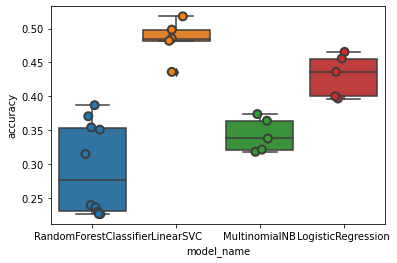

In [74]:
### خلاص هذي ما نحتاجها 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    ]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [73]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.483934
LogisticRegression        0.430820
MultinomialNB             0.342951
RandomForestClassifier    0.231475
Name: accuracy, dtype: float64

<1143x7254 sparse matrix of type '<class 'numpy.float64'>'
	with 41313 stored elements in Compressed Sparse Row format>

<1143x7528 sparse matrix of type '<class 'numpy.float64'>'
	with 52817 stored elements in Compressed Sparse Row format>

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df["clean_text_stopward"], df['dominant_topic'], random_state = 0)

In [60]:
# Count Vector
cv = CountVectorizer(stop_words="english")
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

# TFIDF
tf = TfidfVectorizer(stop_words="english")
X_train_tf = tf.fit_transform(X_train)
X_test_tf = tf.transform(X_test)

# TFIDF
tf_2 = TfidfVectorizer(ngram_range = (1,2), stop_words="english")
X_train_tf_2 = tf.fit_transform(X_train)
X_test_tf_2 = tf.transform(X_test)

In [79]:
X_train_counts

<1143x7528 sparse matrix of type '<class 'numpy.int64'>'
	with 52817 stored elements in Compressed Sparse Row format>

In [84]:
from sklearn.metrics import f1_score


lr = LogisticRegression()
lr.fit(X_train_tf, y_train)
y_pred = lr.predict(X_train_tf)
print(f"F:", f1_score(y_train, y_pred, average='weighted'))
print("Precision :", precision_score(y_train, y_pred, average='weighted'))
print("Recall :", recall_score(y_train, y_pred, average='weighted'))

F: 0.7658510077976336
Precision : 0.826894942006955
Recall : 0.7952755905511811


C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
models, metric_df = make_exprs([    modeling("LogisticRegression with CV",LogisticRegression(), 
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("LogisticRegression with TFIDF", LogisticRegression(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                    modeling("Naive Bayes with CV", MultinomialNB(),
                                             X_train_cv, y_train, X_test_cv, y_test),
                                    modeling("Naive Bayes with TFIDf", MultinomialNB(),
                                             X_train_tf, y_train, X_test_tf, y_test),
                                    modeling("LogisticRegression with TFIDF ngram_range = (1,2)",
                                             LogisticRegression(), X_train_tf_2, y_train, X_test_tf_2, y_test),
                                    modeling("Naive Bayes with TFIDF ngram_range = (1,2)",
                                             MultinomialNB(), X_train_tf_2, y_train, X_test_tf_2, y_test)
                                    ])

################### LogisticRegression with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.9956255468066492
Precision Score: 0.995679990489274
Recall Score: 0.9956255468066492
F1 Score: 0.9956066129179196
________________ Test Metrics______________
Accuarcy score: 0.46335078534031415
Precision Score: 0.45181621420943546
Recall Score: 0.46335078534031415
F1 Score: 0.44155363695343247


C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


################### LogisticRegression with TFIDF ###################
________________ Train Metrics______________
Accuarcy score: 0.7952755905511811
Precision Score: 0.826894942006955
Recall Score: 0.7952755905511811
F1 Score: 0.7658510077976336
________________ Test Metrics______________
Accuarcy score: 0.387434554973822
Precision Score: 0.3336849707076583
Recall Score: 0.387434554973822
F1 Score: 0.3070883530005276
################### Naive Bayes with CV ###################
________________ Train Metrics______________
Accuarcy score: 0.8276465441819773
Precision Score: 0.873478346215714
Recall Score: 0.8276465441819773
F1 Score: 0.8182739895414085
________________ Test Metrics______________
Accuarcy score: 0.36649214659685864
Precision Score: 0.4391452019641091
Recall Score: 0.36649214659685864
F1 Score: 0.29146359031381247
################### Naive Bayes with TFIDf ###################
________________ Train Metrics______________
Accuarcy score: 0.4575678040244969
Precision Score: 0

C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM

################### LogisticRegression with TFIDF ngram_range = (1,2) ###################
________________ Train Metrics______________
Accuarcy score: 0.7952755905511811
Precision Score: 0.826894942006955
Recall Score: 0.7952755905511811
F1 Score: 0.7658510077976336
________________ Test Metrics______________
Accuarcy score: 0.387434554973822
Precision Score: 0.3336849707076583
Recall Score: 0.387434554973822
F1 Score: 0.3070883530005276
################### Naive Bayes with TFIDF ngram_range = (1,2) ###################
________________ Train Metrics______________
Accuarcy score: 0.4575678040244969
Precision Score: 0.5406356535626257
Recall Score: 0.4575678040244969
F1 Score: 0.36360535757890045
________________ Test Metrics______________
Accuarcy score: 0.2617801047120419
Precision Score: 0.23604922692542035
Recall Score: 0.2617801047120419
F1 Score: 0.15141277055380026


C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\REEEM\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedM